<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>


# 1. Finding Patterns in DNA

The GC skew diagram for [Salmonella Typhimurium](http://csbio.unc.edu/mcmillan/Comp555S18/data/SalmonellaTyphimurium.fa). How to estimate the position of the OriC?

In [2]:
def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained"""
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rb')
    else:
        fp = open(filename, 'rb')
    # split at headers
    data = fp.read().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        # add an extra "+" to make string "1-referenced"
        sequences.append('+' + ''.join(lines))
    return (headers, sequences)

4081397 is the estimated OriC position


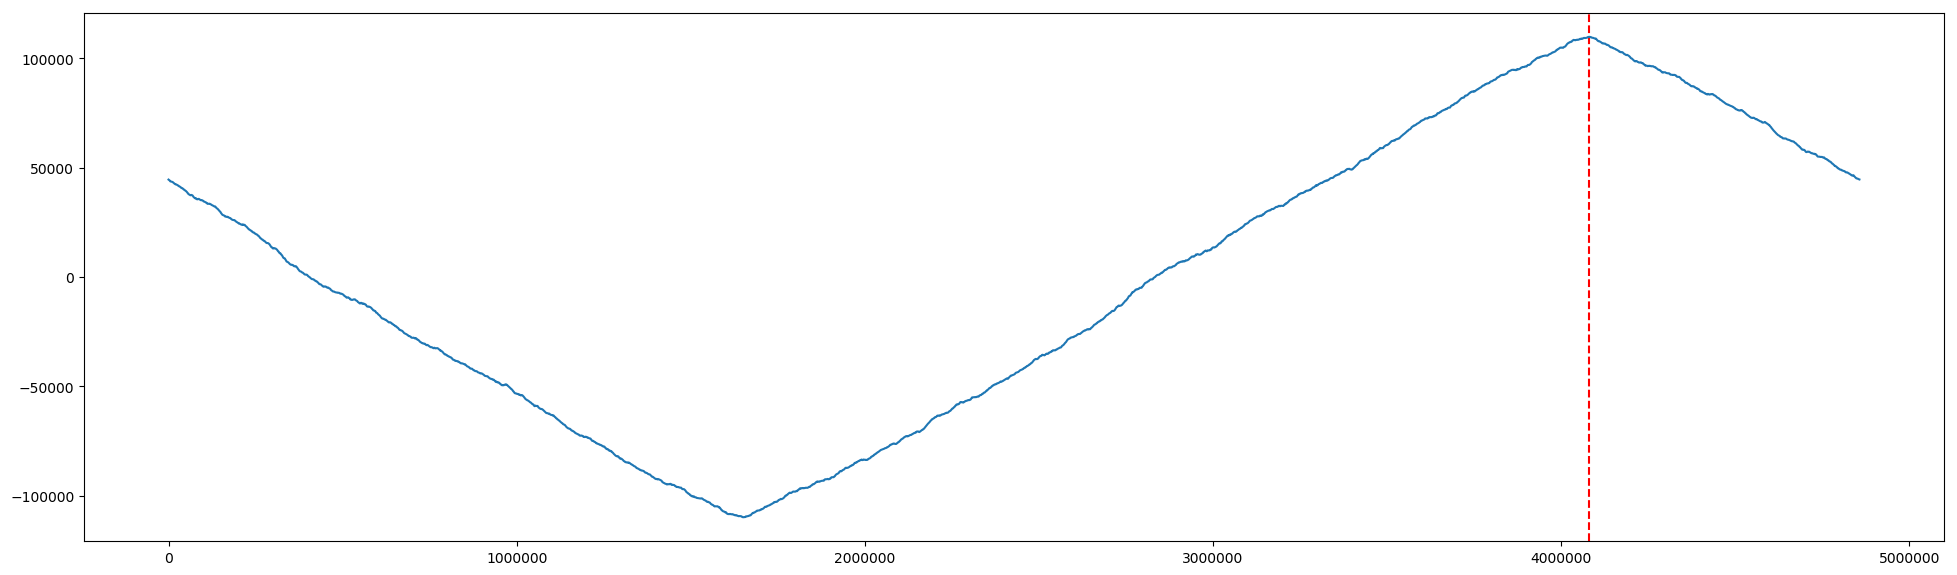

In [3]:
import numpy 

def GCSkew(sequence): 
    half = len(sequence)//2 
    full = len(sequence) 
    genome = numpy.fromstring(sequence+sequence, dtype='uint8') 
    matchC = numpy.concatenate(([0], numpy.array(genome == ord('C'), dtype="int8").cumsum())) 
    matchG = numpy.concatenate(([0], numpy.array(genome == ord('G'), dtype="int8").cumsum())) 
    matchGC = matchG - matchC 
    skew = matchGC[half:half+full]-matchGC[0:full]+matchGC[full-half:2*full-half]-matchGC[full:2*full] 
    return skew 

header, seq = loadFasta("SalmonellaTyphimurium.fa")

%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 

y = GCSkew(seq[0][1:]) 
oriCGuess = y.argmax() + 1 
N = len(y) 
plt.figure(num=None, figsize=(24, 7), dpi=100) 
plt.axvline(oriCGuess, color="r", linestyle='--') 
result = plt.plot(range(0,N,1000), y[0:N:1000]) 
print oriCGuess, "is the estimated OriC position"

Searching for motifs by a branch-and-bound algorithm.

In [9]:
import itertools 

def ScanAndScoreMotif(DNA, motif):
    totalDist = 0
    bestAlignment = []
    k = len(motif)
    for seq in DNA:
        minHammingDist = k+1
        for s in xrange(len(seq)-k+1):
            HammingDist = sum([1 for i in xrange(k) if motif[i] != seq[s+i]])
            if (HammingDist < minHammingDist):
                bestS = s
                minHammingDist = HammingDist
        bestAlignment.append(bestS)
        totalDist += minHammingDist
    return bestAlignment, totalDist


def BranchAndBoundMedianStringMotifSearch(DNA, k, prefix=''): 
    global bestAlignment, minHammingDist, bestkmer 
    if len(prefix) == 0: 
        bestAlignment = [] 
        minHammingDist = k*len(DNA) 
        bestkmer = "?"
        
    # score the current prefix 
    align, dist = ScanAndScoreMotif(DNA,prefix) 
    # if the prefix is of length k, we should consider it 
    if len(prefix) == k: 
    # only set new "best" variables if the score for the prefix improves the best score 
        if(dist < minHammingDist): 
            bestAlignment = [a for a in align] 
            minHammingDist = dist 
            bestkmer = prefix 
        else: 
        # only branch if the score for the prefix is still less than the best score 
            if(dist < minHammingDist): 
                for base in "acgt": 
                    BranchAndBoundMedianStringMotifSearch(DNA, k, prefix+base) 
        return bestAlignment, minHammingDist, bestkmer 

In [7]:
seqApprox = [ 
'tagtggtcttttgagtgtagatctgaagggaaagtatttccaccagttcggggtcacccagcagggcagggtgacttaat', 
'cgcgactcggcgctcacagttatcgcacgtttagaccaaaacggagttggatccgaaactggagtttaatcggagtcctt', 
'gttacttgtgagcctggttagacccgaaatataattgttggctgcatagcggagctgacatacgagtaggggaaatgcgt', 
'aacatcaggctttgattaaacaatttaagcacgtaaatccgaattgacctgatgacaatacggaacatgccggctccggg', 
'accaccggataggctgcttattaggtccaaaaggtagtatcgtaataatggctcagccatgtcaatgtgcggcattccac', 
'tagattcgaatcgatcgtgtttctccctctgtgggttaacgaggggtccgaccttgctcgcatgtgccgaacttgtaccc', 
'gaaatggttcggtgcgatatcaggccgttctcttaacttggcggtgcagatccgaacgtctctggaggggtcgtgcgcta', 
'atgtatactagacattctaacgctcgcttattggcggagaccatttgctccactacaagaggctactgtgtagatccgta', 
'ttcttacacccttctttagatccaaacctgttggcgccatcttcttttcgagtccttgtacctccatttgctctgatgac', 
'ctacctatgtaaaacaacatctactaacgtagtccggtctttcctgatctgccctaacctacaggtcgatccgaaattcg'] 

%time myAnswer=BranchAndBoundMedianStringMotifSearch(seqApprox,10)

Wall time: 1e+03 µs
